A to-do list (delete later):
- Explore libraries for visualising missing data in Python 
- Deal with the missing data in both datasets 
- Sort out all of the mess below 
- Include plots that illustrate cool trends in the data
- Find strongest correlations
- Compare the datasets from both years

## Introduction

I obtained data on Airbnbs in Edinburgh for both 2019/20 (compiled on 25th June 2019) and 2020/21 (compiled on 23rd June 2020). All of the data were collected by the [Inside Airbnb](http://insideairbnb.com/get-the-data.html) project, although only the most recent year is available on their website. The 2019-20 data were sourced on [Kaggle](https://www.kaggle.com/thoroc/edinburgh-inside-airbnb). Here, I take a first look at the **listings** from the **2019/20** data.

The data has 106 fields describing 13,245 Airbnb listings.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

listings = pd.read_csv('../data19/listings.csv')
listings.shape

(13245, 106)

## Missing Data

There are missing data in this dataset. 

In [9]:
listings.isna().any().any()

True

In [11]:
listings.loc[:, listings.isnull().any()].columns

Index(['name', 'summary', 'space', 'description', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'xl_picture_url', 'host_name',
       'host_since', 'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'bathrooms', 'bedrooms', 'beds', 'square_feet', 'weekly_price',
       'monthly_price', 'security_deposit', 'cleaning_fee', 'first_review',
       'last_review', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_s

## Exploring Pricing

First I transform the price columns into numeric values.

In [12]:
from pandas.api.types import is_numeric_dtype

def format_price(dataframe, column):
    if not is_numeric_dtype(dataframe[column]):
        dataframe[column] = dataframe[column].str.replace('$', '')
        dataframe[column] = dataframe[column].str.replace(',', '')
        dataframe[column] = pd.to_numeric(dataframe[column])

format_price(listings, "price")
format_price(listings, "extra_people")

Airbnbs can opt to charge extra for additional people staying in larger properties. The `price` column only refers to `guests_included`, and additional guests are charged at `extra_people`. Therefore, I can create another column which is price per included guest (`price_pig` = `price`/`guests_included`). I can also create a column that is price at full capacity (`price_fullcap` = `price` + `extra_people` * (`accomodates` - `guests_included`)). On 6 occassions this results in a negative number for `price_fullcap`, because the owner of the Airbnb has listed the price as including more individuals than the property can accomodate. In such cases, `price_fullcap` is just set to `price`.

In [13]:
listings = listings.assign(price_pig = lambda dataframe : dataframe['price']/dataframe['guests_included'])

listings = listings.assign(price_fullcap = lambda dataframe : dataframe['price'] + dataframe['extra_people'] * (dataframe['accommodates'] - dataframe['guests_included']))

listings.query('price_pig > price_fullcap')[['price_pig', 'price_fullcap', 'accommodates', 'price', 'extra_people', 'guests_included']]

listings['price_fullcap'] = np.where((listings.price_pig > listings.price_fullcap),listings.price,listings.price_fullcap)

### Distributions and Outlier Detection 

The histogram of price per included guest shows an extreme right skew. Price here refers to the **mean** price per included guests per night over a 365 day period. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019F2F9E9548>]],
      dtype=object)

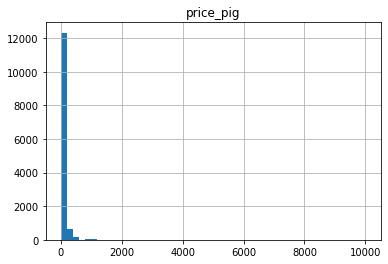

In [14]:
listings.hist(column = 'price_pig', bins = 50)

There are values of a dataset where the price per included guest is 0. The maximum price per included guest per night is £9,999. A really special feature of this dataset is that it includes the links to the Airbnb's pages. This means that, so long as the listing is still active, I can literally check to see if there is a reason that a value is extreme. I choose to use my own knowledge of hotel prices to create sensible upper and lower bounds for the data. Personally, I have found statistical methods (e.g. 3 standard deviations) often hide real features of the data. I use the price per included guest to make these judgements, because a property may appear to be an outlier just because it sleeps a large number of individuals. 

In [27]:
print(listings['price_pig'].min())
print(listings['price_pig'].max())

0.0
9999.0


Any Airbnb less than £8 per person a night would be a potential outlier, as this seems unreasonably cheap. There are 18 Airbnbs under £8 a night, and two of these are listed as costing nothing at all. I visually inspect these properties in the data for any feature that might explain this (e.g. they all have the same host, or are a special property type...). Airbnbs under £8 per person tend include many more people in the base rate than the mean for all Airbnbs in this dataset (mean ± standard deviation: 7.83 ± 4.93 vs 1.77 ± 1.50). It makes sense that Airbnbs that include more people would be cheaper per person because the 'bare minimum' costs to the host are split between all of the people. These are the same trends that I observed in the 2020-21 data (but not these datasets are not independent - many of the Airbnbs are present in both datasets!).

In [24]:
listings[listings.price_pig < 8][['price_pig', 'minimum_nights', 'listing_url', 'host_id', 'guests_included', 'availability_365', 'beds', 'property_type', 'extra_people']]

,price_pig,minimum_nights,listing_url,host_id,guests_included,availability_365,beds,property_type,extra_people
655,7.000000,1,https://www.airbnb.com/rooms/3032366,14630118,6,84,3.0,Apartment,15.0
900,2.600000,3,https://www.airbnb.com/rooms/3769281,3713949,15,21,1.0,Apartment,0.0
1064,6.250000,1,https://www.airbnb.com/rooms/4453978,23112161,4,0,2.0,Apartment,20.0
3017,2.916667,3,https://www.airbnb.com/rooms/12512258,67762663,12,110,1.0,House,0.0
3762,2.916667,1,https://www.airbnb.com/rooms/13937408,82866543,12,314,1.0,Apartment,10.0
5373,2.272727,1,https://www.airbnb.com/rooms/18609453,101731795,11,125,1.0,Townhouse,0.0
5851,5.000000,1,https://www.airbnb.com/rooms/19402102,136012860,4,0,2.0,Apartment,0.0
6343,4.062500,3,https://www.airbnb.com/rooms/19903475,140937670,16,92,1.0,Apartment,0.0
6630,0.000000,5,https://www.airbnb.com/rooms/20177668,106987467,1,0,1.0,Apartment,0.0
6948,0.000000,2,https://www.airbnb.com/rooms/20752585,2689840,1,0,1.0,Apartment,0.0


In fact, if I filter the results to only include Airbnbs with less than 5 guests (I choose this number because it is two deviations away from the mean for the whole sample), then I am only left with 6 results. Two of these are most likely errors as they are £0. I choose to exclude these 6 results.

In [29]:
listings[(listings.price_pig < 8) & (listings.guests_included < 5)][['price_pig', 'minimum_nights', 'listing_url', 'host_id', 'guests_included', 'availability_365', 'beds', 'property_type', 'extra_people']]

,price_pig,minimum_nights,listing_url,host_id,guests_included,availability_365,beds,property_type,extra_people
1064,6.25,1,https://www.airbnb.com/rooms/4453978,23112161,4,0,2.0,Apartment,20.0
5851,5.00,1,https://www.airbnb.com/rooms/19402102,136012860,4,0,2.0,Apartment,0.0
6630,0.00,5,https://www.airbnb.com/rooms/20177668,106987467,1,0,1.0,Apartment,0.0
6948,0.00,2,https://www.airbnb.com/rooms/20752585,2689840,1,0,1.0,Apartment,0.0
9735,5.00,2,https://www.airbnb.com/rooms/27163272,119509555,2,289,2.0,Apartment,20.0


In [30]:
listings = listings[(listings.price > 8) | (listings.guests_included >= 5)]

A luxury apartment might charge £1000 a night per person if it was also centrally located. Moreover, recall that price here is derived from the mean price, so Airbnbs that are exclusively available on the night of some special event (e.g. the Edinburgh Hogmanay festival) may seem inflated compared to others. Thirty-six Airbnbs exceed £1000 per night per person. Some hosts are very common in this subset. I could find no justification for these high values outside of error or an unusual quirk of availability (which unfortunately, I cannot correct for with the data I have), so I decided to exclude these data points.

In [34]:
listings[listings.price_pig > 1000][['price_pig', 'minimum_nights', 'listing_url', 'host_id', 'guests_included', 'availability_365', 'beds', 'property_type', 'extra_people', 'has_availability']]

,price_pig,minimum_nights,listing_url,host_id,guests_included,availability_365,beds,property_type,extra_people,has_availability
378,2600.00,2,https://www.airbnb.com/rooms/1367733,646220,2,0,1.0,Apartment,0.0,t
913,6747.00,1,https://www.airbnb.com/rooms/3797987,19504588,1,335,5.0,Apartment,18.0,t
994,1134.50,2,https://www.airbnb.com/rooms/4167650,20923270,2,15,3.0,Apartment,10.0,t
995,1133.00,2,https://www.airbnb.com/rooms/4167874,20923270,2,26,2.0,Apartment,10.0,t
2987,1500.00,1,https://www.airbnb.com/rooms/12385633,21782787,1,0,1.0,Apartment,0.0,t
3636,5000.00,1,https://www.airbnb.com/rooms/13745807,80447250,1,89,4.0,Apartment,0.0,t
3640,3000.00,1,https://www.airbnb.com/rooms/13756769,80447250,1,89,3.0,Apartment,0.0,t
3641,7000.00,1,https://www.airbnb.com/rooms/13756895,80447250,1,89,5.0,Apartment,0.0,t
3642,7000.00,1,https://www.airbnb.com/rooms/13756984,80447250,1,89,6.0,Apartment,0.0,t
4018,2354.00,1,https://www.airbnb.com/rooms/14225887,86457709,1,0,1.0,Apartment,0.0,t


In [35]:
listings = listings[(listings.price < 1000)]

The skew in price per included guest is still very extreme. However, I am unwilling to blindly remove any more data points at this stage without further justification for their removal. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019F3E6A40C8>]],
      dtype=object)

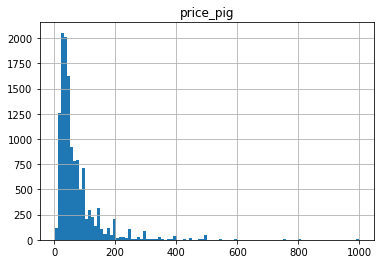

In [36]:
listings.hist(column = 'price_pig', bins = 100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019F3E694388>]],
      dtype=object)

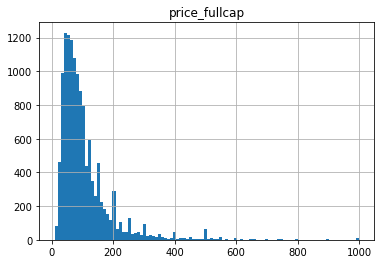

In [37]:
listings.hist(column = 'price_fullcap', bins = 100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019F3DD99088>]],
      dtype=object)

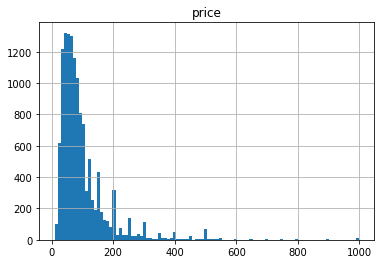

In [38]:
listings.hist(column = 'price', bins = 100)

## Exploring Ameneties

Below, I add a column that indicates whether an Airbnb has a real bed or not. I also pull a number of different amenities out of the ameneites column.

In [41]:
listings.amenities.head()

0    {TV,Internet,Wifi,"Wheelchair accessible",Kitc...
1    {TV,Wifi,Kitchen,"Paid parking off premises",E...
2    {TV,Internet,Wifi,"Wheelchair accessible",Kitc...
3    {TV,"Cable TV",Internet,Wifi,Kitchen,"Pets liv...
4    {TV,Wifi,Kitchen,"Paid parking off premises",H...
Name: amenities, dtype: object

In [42]:
listings['real_bed'] = listings['bed_type'].apply(lambda x: 1 if (x == 'Real Bed') else 0)

def countAmenities(search_term, col_name):
    listings[col_name] = listings['amenities'].apply(lambda x: 1 if search_term in x else 0)
    return(listings)

amenitiesDict = {
    "pets": "Pets allowed",
    "children": "Family/kid friendly",
    "aircon": "Air conditioning",
    "wifi": "Wifi",
    "washer": "Washer",
    "garden": "Garden or backyard",
    "oven": "Oven",
    "gym": "Gym",
    "tv": "TV",
    "cable": "Cable TV",
    "free_parking": "Free parking on premises",
    "breakfast": "Breakfast",
    "dishwasher": "Dishwasher",
    "crib": "Crib",
    "workspace": "Laptop friendly workspace",
    "lift": "Elevator",
    "wheelchair_access": "Wheelchair accessible",
    "balcony": "Patio or balcony",
    "bathtub": "Bathtub",
    "lugagge_dropoff": "Luggage dropoff allowed",
    "self_checkin": "Self check-in",
    "dryer": "Dryer",
    "waterfront": "Waterfront",
    "fireplace": "Indoor fireplace"
}


for key in amenitiesDict:
    listings = countAmenities(amenitiesDict[key], key)

None of the amenities features are strongly correlated with price: their correlations are all less than 0.1, with the exception of a tumble dryer. Other features positively correlated with price are lifts and TVs. Perhaps surprisingly, features negatively correlated with price are breakfast, ovens, and self check-ins.

In [43]:
corrMatrix = listings[["price", "price_pig", "price_fullcap"] + list(amenitiesDict.keys())].corr()
corrMatrix["price_pig"].sort_values()

oven                -0.064330
self_checkin        -0.057463
breakfast           -0.054166
garden              -0.051164
workspace           -0.041151
wifi                -0.037080
lugagge_dropoff     -0.036052
free_parking        -0.034600
waterfront          -0.019947
bathtub             -0.013262
balcony             -0.013124
wheelchair_access   -0.003191
dishwasher          -0.002388
gym                 -0.001707
pets                -0.000009
cable                0.004842
children             0.022232
aircon               0.029414
lift                 0.031429
crib                 0.038917
washer               0.058020
fireplace            0.067286
tv                   0.092517
dryer                0.105302
price_fullcap        0.748621
price                0.814391
price_pig            1.000000
Name: price_pig, dtype: float64

The columns `space`, `description`, `neighborhood_overview`, `summary` and `notes` offer large prose added by the owners of the Airbnb. At this moment in time, I choose to stick with the ameneties I have extracted, although these could be a source of further data.

I collapse together housing types and one hot encode them. Surprisingly, the only correlation greater than 0.1 is for hostels: for all price types, hostels correlate positively with price! I find this surprising given hostels reputations as cheap places to stay. However, this could be influenced by the fact that hostels are more likely to be in central areas; hostels advertised as Airbnbs are not typical hostels; or that hostels are uncommon in the dataset thus susceptible to the influences of outliers. 

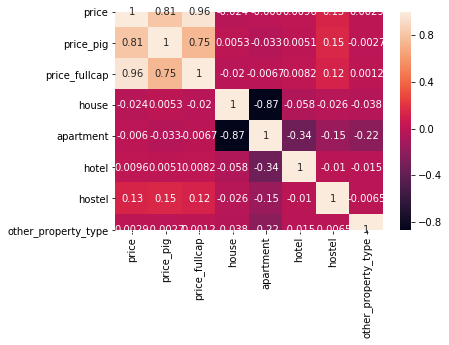

,price,price_pig,price_fullcap,house,apartment,hotel,hostel,other_property_type
price,1.000000,0.814391,0.963134,-0.023932,-0.005963,0.009566,0.129199,0.002935
price_pig,0.814391,1.000000,0.748621,0.005302,-0.033412,0.005140,0.152829,-0.002724
price_fullcap,0.963134,0.748621,1.000000,-0.019822,-0.006653,0.008203,0.117819,0.001167
house,-0.023932,0.005302,-0.019822,1.000000,-0.867023,-0.058364,-0.025913,-0.037675
apartment,-0.005963,-0.033412,-0.006653,-0.867023,1.000000,-0.336670,-0.149476,-0.217325
hotel,0.009566,0.005140,0.008203,-0.058364,-0.336670,1.000000,-0.010062,-0.014629
hostel,0.129199,0.152829,0.117819,-0.025913,-0.149476,-0.010062,1.000000,-0.006495
other_property_type,0.002935,-0.002724,0.001167,-0.037675,-0.217325,-0.014629,-0.006495,1.000000


In [45]:
listings['house'] = listings['property_type'].apply(lambda x: 1 if x in ['House', 'Cottage', 'Townhouse', 'Bungalow', 'Tiny house'] else 0)
listings['apartment'] = listings['property_type'].apply(lambda x: 1 if x in ['Apartment', 'Serviced apartment', 'Condominium', 'Aparthotel'] else 0)
listings['hotel'] = listings['property_type'].apply(lambda x: 1 if x in ['Boutique hotel', 'Guest suite', 'Guesthouse', 'Hotel', 'Bed and breakfast'] else 0)
listings['hostel'] = listings['property_type'].apply(lambda x: 1 if x in ['Hostel'] else 0)
listings['other_property_type'] = listings['property_type'].apply(lambda x: 1 if x in ['Loft', 'Villa', 'Camper/RV', 'Other', 'Tent', 'Cabin', 'Campsite', 'Chalet', 'Hut', 'Casa particular (Cuba)', 'Farm stay', 'Barn', 'Boat'] else 0)

corrMatrix = listings[['price', 'price_pig', 'price_fullcap', 'house', 'apartment', 'hotel', 'hostel', 'other_property_type']].corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()
corrMatrix

## Exploring Neighbourhoods

### One Hot Encoding

I one hot encode the neighbourhoods.

In [96]:
areas = pd.get_dummies(listings.neighbourhood, prefix='Area')
areas['id'] = listings['id']
listings = listings.merge(areas, on = 'id')
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,Area_Leith,Area_Marchmont,Area_Morningside,Area_New Town,Area_Newington,Area_Old Town,Area_Southside,Area_Stockbridge,Area_Tollcross,Area_West End
0,15420,https://www.airbnb.com/rooms/15420,20190625184115,2019-06-25,Georgian Boutique Apt City Centre,"Stunning, impeccably refurbished spacious grou...",This is a huge and luxurious apartment for 2 -...,"Stunning, impeccably refurbished spacious grou...",none,"The neighbourhood is in the historic New Town,...",...,0,0,0,1,0,0,0,0,0,0
1,24288,https://www.airbnb.com/rooms/24288,20190625184115,2019-06-25,"Cool central Loft, sleeps 4, 2 double bed+en-s...",Boho rustic-chic former warehouse Loft located...,"Two bedroom, very central Loft apartment with ...",Boho rustic-chic former warehouse Loft located...,none,It's all in the mix: Culture-museums and galle...,...,0,0,0,0,0,0,1,0,0,0
2,38628,https://www.airbnb.com/rooms/38628,20190625184115,2019-06-26,Edinburgh Holiday Let,Brunstane - Daiches Braes (close to Portobello...,Check out (Website hidden by Airbnb) Free Wi-...,Brunstane - Daiches Braes (close to Portobello...,none,Quiet and easy access to outside.,...,0,0,0,0,0,0,0,0,0,0
3,44552,https://www.airbnb.com/rooms/44552,20190625184115,2019-06-25,Double room - spacious Leith flat,Pleasant double room in 2 bedroom ground floor...,You will be staying in a pleasant double room ...,Pleasant double room in 2 bedroom ground floor...,none,NaN,...,1,0,0,0,0,0,0,0,0,0
4,47616,https://www.airbnb.com/rooms/47616,20190625184115,2019-06-25,"City flat, close to nature and the Fringe",Annemarie & I would like to welcome you to our...,The flat has two floors with bedrooms and bath...,Annemarie & I would like to welcome you to our...,none,We're at the quiet end of a residential street...,...,0,0,0,0,0,0,1,0,0,0


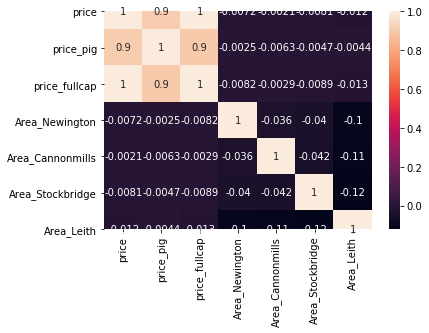

,price,price_pig,price_fullcap,Area_Newington,Area_Cannonmills,Area_Stockbridge,Area_Leith
price,1.000000,0.904882,0.997855,-0.007192,-0.002134,-0.008133,-0.012336
price_pig,0.904882,1.000000,0.901401,-0.002510,-0.006281,-0.004706,-0.004365
price_fullcap,0.997855,0.901401,1.000000,-0.008165,-0.002878,-0.008920,-0.012856
Area_Newington,-0.007192,-0.002510,-0.008165,1.000000,-0.036097,-0.039871,-0.103081
Area_Cannonmills,-0.002134,-0.006281,-0.002878,-0.036097,1.000000,-0.041984,-0.108542
Area_Stockbridge,-0.008133,-0.004706,-0.008920,-0.039871,-0.041984,1.000000,-0.119892
Area_Leith,-0.012336,-0.004365,-0.012856,-0.103081,-0.108542,-0.119892,1.000000


In [97]:
corrMatrix = listings[['price', 'price_pig', 'price_fullcap', 'Area_Newington', 'Area_Cannonmills', 'Area_Stockbridge', 'Area_Leith']].corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()
corrMatrix

In [103]:
listings = listings.drop(listings.iloc[:, 1:19], axis = 1)
listings = listings.drop(listings.columns[listings.columns.str.contains('nights')], axis=1)

for column in listings.columns:
    print(column)

id
street
neighbourhood
neighbourhood_cleansed
neighbourhood_group_cleansed
city
state
zipcode
market
smart_location
country_code
country
latitude
longitude
is_location_exact
property_type
room_type
accommodates
bathrooms
bedrooms
beds
bed_type
amenities
square_feet
price
weekly_price
monthly_price
security_deposit
cleaning_fee
guests_included
extra_people
calendar_updated
has_availability
availability_30
availability_60
availability_90
availability_365
calendar_last_scraped
number_of_reviews
number_of_reviews_ltm
first_review
last_review
review_scores_rating
review_scores_accuracy
review_scores_cleanliness
review_scores_checkin
review_scores_communication
review_scores_location
review_scores_value
requires_license
license
jurisdiction_names
instant_bookable
is_business_travel_ready
cancellation_policy
require_guest_profile_picture
require_guest_phone_verification
calculated_host_listings_count
calculated_host_listings_count_entire_homes
calculated_host_listings_count_private_rooms
cal

## Exploring Ratings and Host Characteristics

### Distributions and Outlier Detection

## Finishing the Dataset

Of the 13,245 properties in the 2019-21 dataset, 9945 of these are also present in the 2020-21 dataset.

In [23]:
listings20 = pd.read_csv('../data20/listings.csv')

for key in amenitiesDict:
    listings20 = countAmenities(amenitiesDict[key], key)
    
listings20 = listings20.merge(areas, on = 'id')

format_price(listings, "price")
format_price(listings, "extra_people")

listings20.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,Area_Leith,Area_Marchmont,Area_Morningside,Area_New Town,Area_Newington,Area_Old Town,Area_Southside,Area_Stockbridge,Area_Tollcross,Area_West End
0,15420,https://www.airbnb.com/rooms/15420,20200623173438,2020-06-24,Georgian Boutique Apt City Centre,"Stunning, impeccably refurbished spacious grou...",This is a huge and luxurious apartment for 2 -...,"Stunning, impeccably refurbished spacious grou...",none,"The neighbourhood is in the historic New Town,...",...,0,0,0,1,0,0,0,0,0,0
1,24288,https://www.airbnb.com/rooms/24288,20200623173438,2020-06-24,"Cool central Loft, sleeps 4, 2 double bed+en-s...",Boho rustic-chic former warehouse Loft located...,"Two bedroom, very central Loft apartment with ...",Boho rustic-chic former warehouse Loft located...,none,It's all in the mix: Culture-museums and galle...,...,0,0,0,0,0,0,1,0,0,0
2,38628,https://www.airbnb.com/rooms/38628,20200623173438,2020-06-24,Edinburgh Holiday Let,Brunstane - Daiches Braes (close to Portobello...,Check out (Website hidden by Airbnb) Free Wi-...,Brunstane - Daiches Braes (close to Portobello...,none,Quiet and easy access to outside.,...,0,0,0,0,0,0,0,0,0,0
3,44552,https://www.airbnb.com/rooms/44552,20200623173438,2020-06-24,Double room - spacious Leith flat,Pleasant double room in 2 bedroom ground floor...,You will be staying in a pleasant double room ...,Pleasant double room in 2 bedroom ground floor...,none,NaN,...,1,0,0,0,0,0,0,0,0,0
4,47616,https://www.airbnb.com/rooms/47616,20200623173438,2020-06-24,"City flat, close to nature and the Fringe",Annemarie & I would like to welcome you to our...,The flat has two floors with bedrooms and bath...,Annemarie & I would like to welcome you to our...,none,We're at the quiet end of a residential street...,...,0,0,0,0,0,0,1,0,0,0


In [25]:
pd.merge(listings, listings20, on = 'id', how = 'inner')

,id,listing_url_x,scrape_id_x,last_scraped_x,name_x,summary_x,space_x,description_x,experiences_offered_x,neighborhood_overview_x,...,Area_Leith,Area_Marchmont,Area_Morningside,Area_New Town,Area_Newington,Area_Old Town,Area_Southside,Area_Stockbridge,Area_Tollcross,Area_West End
0,15420,https://www.airbnb.com/rooms/15420,20200623173438,2020-06-24,Georgian Boutique Apt City Centre,"Stunning, impeccably refurbished spacious grou...",This is a huge and luxurious apartment for 2 -...,"Stunning, impeccably refurbished spacious grou...",none,"The neighbourhood is in the historic New Town,...",...,0,0,0,1,0,0,0,0,0,0
1,24288,https://www.airbnb.com/rooms/24288,20200623173438,2020-06-24,"Cool central Loft, sleeps 4, 2 double bed+en-s...",Boho rustic-chic former warehouse Loft located...,"Two bedroom, very central Loft apartment with ...",Boho rustic-chic former warehouse Loft located...,none,It's all in the mix: Culture-museums and galle...,...,0,0,0,0,0,0,1,0,0,0
2,38628,https://www.airbnb.com/rooms/38628,20200623173438,2020-06-24,Edinburgh Holiday Let,Brunstane - Daiches Braes (close to Portobello...,Check out (Website hidden by Airbnb) Free Wi-...,Brunstane - Daiches Braes (close to Portobello...,none,Quiet and easy access to outside.,...,0,0,0,0,0,0,0,0,0,0
3,44552,https://www.airbnb.com/rooms/44552,20200623173438,2020-06-24,Double room - spacious Leith flat,Pleasant double room in 2 bedroom ground floor...,You will be staying in a pleasant double room ...,Pleasant double room in 2 bedroom ground floor...,none,NaN,...,1,0,0,0,0,0,0,0,0,0
4,47616,https://www.airbnb.com/rooms/47616,20200623173438,2020-06-24,"City flat, close to nature and the Fringe",Annemarie & I would like to welcome you to our...,The flat has two floors with bedrooms and bath...,Annemarie & I would like to welcome you to our...,none,We're at the quiet end of a residential street...,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9940,36059614,https://www.airbnb.com/rooms/36059614,20200623173438,2020-06-24,"The Knight Residence, 1 Bedroom City","Elegant and traditional apartment, which provi...","Located in the main building, facing on to Lau...","Elegant and traditional apartment, which provi...",none,To walk from Waverley station: walk west to th...,...,0,0,0,0,0,0,0,0,1,0
9941,36060353,https://www.airbnb.com/rooms/36060353,20200623173438,2020-06-24,"The Knight Residence, 2 Bedroom City","Elegant and traditional apartment, which provi...",Located in the main building facing overlookin...,"Elegant and traditional apartment, which provi...",none,To walk from Waverley station: walk west to th...,...,0,0,0,0,0,0,0,0,1,0
9942,36061191,https://www.airbnb.com/rooms/36061191,20200623173438,2020-06-24,"The Knight Residence, 1 Bedroom Comfort","Elegant and traditional apartment, which provi...",Located in our annex building these apartments...,"Elegant and traditional apartment, which provi...",none,To walk from Waverley station: walk west to th...,...,0,0,0,0,0,0,0,0,1,0
9943,36061722,https://www.airbnb.com/rooms/36061722,20200623173438,2020-06-24,"The Knight Residence, 2 Bedroom Comfort","Elegant and traditional apartment, which provi...",Located in our annex building these apartments...,"Elegant and traditional apartment, which provi...",none,To walk from Waverley station: walk west to th...,...,0,0,0,0,0,1,0,0,0,0


In [33]:
corr_matrix = listings20.corr().abs()

#the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)

sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))

sol

host_listings_count             host_total_listings_count                      1.000000e+00
maximum_maximum_nights          maximum_nights_avg_ntm                         9.955196e-01
minimum_maximum_nights          maximum_nights_avg_ntm                         9.950020e-01
calculated_host_listings_count  calculated_host_listings_count_entire_homes    9.935348e-01
minimum_minimum_nights          minimum_nights_avg_ntm                         9.929071e-01
                                                                                   ...     
scrape_id                       Area_Stockbridge                               1.547409e-16
                                review_scores_accuracy                         1.135993e-16
                                maximum_maximum_nights                         6.150043e-17
                                minimum_nights                                 3.684382e-17
                                Area_Southside                                 3

## Comparison of 2019-20 and 2020-21

In [ ]:
Look for associations between area and house type, amenities, etc 

## Prepare Datasets for Modelling

Acceptance rate is empty. Response time is a categorical variable, response rate is a % (% of individuals responded to).

In [102]:
listings.city.value_counts()

Edinburgh                           12958
Edinburgh                              90
Edimburgo                              20
Queensferry                            15
Currie                                 14
                                    ...  
Cramond Village, near Edinburgh         1
Edinburgh, Scotland, EH6 5PU            1
Kirkliston, Edinburgh                   1
Leith                                   1
Stockbridge, New Town, Edinburgh        1
Name: city, Length: 63, dtype: int64

So few do not have profile pictures it's probably not useful. Lisence is also not useful. Host location may be informative.

In [107]:
#listings.host_location.value_counts()
#listings.host_has_profile_pic.value_counts()
listings.review_scores_value.value_counts()

10.0    6481
9.0     3862
8.0      529
7.0       79
6.0       77
2.0       11
4.0       10
5.0        8
Name: review_scores_value, dtype: int64

In [248]:
listings.calculated_host_listings_count_entire_homes.value_counts()

1      5849
0      4127
2      1115
3       441
4       215
5       161
7       151
135     135
6       103
90       90
9        84
14       84
39       78
65       74
12       73
27       54
15       45
10       42
41       41
11       33
29       29
23       29
28       28
25       25
8        24
19       22
22       22
20       21
21       21
16       16
13       13
Name: calculated_host_listings_count_entire_homes, dtype: int64